# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

Each **project group** will submit a single **jupyter notebook** which contains:

1. (1\%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.
2. (2\%) Obtains, cleans, and merges all data sources involved in the project.
3. (2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

#### Introduction

In today's times, a player's popularity on social media is a defining factor to how long they would continue the contract with the team, since a popular team gets the most fans thus the most tickets sold, merchandise bought, and better revenue in general. Moreover, we also wanted to find out if their on-field performance like how many goals they score or the way they interact with their teammates also affects popularity on social media. This complete analysis could also help the clubs themselves understand which players they could trade off, or are valuable to their team. 


## Gathering Twitter Data
### Sources
- https://builtin.com/articles/selenium-web-scraping
- https://www.selenium.dev/documentation/webdriver/elements/finders/
- https://www.selenium.dev/documentation/webdriver/actions_api/wheel/
- https://selenium-python.readthedocs.io/locating-elements.html

*Note: Twitter pages first load JavaScript (that then fetches the data) so BeautifulSoup won't work here*

In [ ]:
# Selenium: Python library used for automating web browser for web scraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import pandas as pd
import time
from datetime import datetime

In [ ]:
# scrapes given url and gathers profile and tweet data
def extractTwitterData(url, scroll_amount, team):
    """ Scrapes given Twitter/X profile page to gather profile and tweet data
    Requires ChromeDriver installation [update executable path once installed]
    
    Args:
        url(str): URL of Twitter/X profile (ex: 'https://x.com/ManCity')
        scroll_amount(int): Number of times the page is scrolled to load tweets
        team: team username for finding page elements (ex: 'ManCity')

    Returns:
        profile_data(dict): Dictionary of profile information
        all_tweets_data(dict): List of dictionaries of individual tweet data
    """
    cService = webdriver.ChromeService(executable_path='/Users/KinseyBellerose/Downloads/chromedriver-mac-arm64/chromedriver')
    driver = webdriver.Chrome(service=cService)
    driver.get(url)
    time.sleep(5) # let the page load

    profile_data = extractProfileData(driver, team)
    all_tweets_data = []

    # extract data from tweets as the page is scrolled
    # increase scroll_amount to load more tweets
    for i in range(scroll_amount):
        tweets = driver.find_elements(By.CSS_SELECTOR, 'article[data-testid="tweet"]')
        for tweet in tweets:
            tweet_data = extractTweetData(tweet)
            all_tweets_data.append(tweet_data)
        # scroll down on page
        driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
        time.sleep(5)
    driver.quit() # closes browsers and stops processes
    return profile_data, all_tweets_data


def extractProfileData(driver, team):
    """ Extract profile information from Twitter/X profile
    Args: 
        driver: Selenium web driver open on profile page
        team(str): Team name for finding page elements
    Returns:
        profile_data(dict): Dictionary containing profile data
    """
    profile_data = {
        'display_name': driver.find_element(By.CSS_SELECTOR, '[data-testid="UserName"]').text,
        'join_date': driver.find_element(By.CSS_SELECTOR, '[data-testid="UserJoinDate"]').text,
        'following_count': driver.find_element(By.CSS_SELECTOR, f'a[href="/{team}/following"]').text,
        'follower_count': driver.find_element(By.CSS_SELECTOR, f'[data-testid="primaryColumn"] [href="/{team}/verified_followers"]').text,
        'post_count': driver.find_element(By.XPATH, '//div[@data-testid="primaryColumn"]//div[contains(text(), "posts")]').text,
        'scraped_at': datetime.now(),
        'profile_url': driver.current_url,
        'team': team
    }
    return profile_data

def extractTweetData(tweet):
    """ Extract individual tweet information from Twitter/X profile
    Args:
        tweet: Page content for single tweet
    Returns:
        tweet_data(dict): Dictionary containing tweet data
    """
    tweet_stats = extract_tweet_stats(tweet)
    author = tweet.find_element(By.CSS_SELECTOR, '[data-testid="User-Name"]').text
    # name, username, and other chars were combined in this element
    author_parts = author.split('\n')
    try:
        tweet_text = tweet.find_element(By.CSS_SELECTOR, '[data-testid="tweetText"]').text,
    except Exception as e:
        tweet_text = 'Error retrieving tweet'

    tweet_data = {
                'text': tweet_text,
                'author_name': author_parts[0] if len(author_parts) > 0 else "",
                'author_username': author_parts[1] if len(author_parts) > 1 else "",
                'timestamp': tweet.find_element(By.CSS_SELECTOR, 'time').get_attribute('datetime'),
                'relative_time': tweet.find_element(By.CSS_SELECTOR, 'time').text,
                'tweet_url': tweet.find_element(By.CSS_SELECTOR, 'a[href*="/status/"]').get_attribute('href'),
                'replies': tweet_stats['replies'],
                'reposts': tweet_stats['reposts'],
                'likes': tweet_stats['likes'],
                'views': tweet_stats['views'],
            }
    return tweet_data

def extract_tweet_stats(tweet):
    """ Retrieves reply, repost, like, and view counts from specific tweet web element
    Args:
        tweet: Page content for a tweet
    Returns:
        Dictionary containing tweet statistics with replies, reposts, likes, and view counts uncleaned
    """
    stat_section = tweet.find_element(By.CSS_SELECTOR, '[role="group"]')
    # stat_section returns as "38 91 1.3K 33K"
    stat_text = stat_section.text.split('\n') # turn into list
    return {
        'replies': stat_text[0] if len(stat_text) > 0 else "0",
        'reposts': stat_text[1] if len(stat_text) > 1 else "0", 
        'likes': stat_text[2] if len(stat_text) > 2 else "0",
        'views': stat_text[3] if len(stat_text) > 3 else "0"
    }

In [ ]:
def create_profiles_df(all_profile_data):
    """ Converts profile dictionaries into DataFrame
    Args:
        all_profile_data(dict): List of profile dictionaries for each team
    Returns:
        profiles_df(DataFrame): DataFrame with a row for each team profile
    """
    profiles_series = []
    for profile in all_profile_data:
        profiles_series.append(pd.Series(profile))
    profiles_df = pd.DataFrame(profiles_series)
    return profiles_df

In [ ]:
def create_tweet_df(tweets_data):
    """ Converts a team's tweet dictionaries into a DataFrame
    Args:
        tweets_Data(dict): List of tweet dictionaries for a team
    Returns:
        tweets_df(DataFrame): DataFrame with a row for each individual tweet
    """
    tweet_series = []
    for tweet in tweets_data:
        tweet_series.append(pd.Series(tweet))
    tweets_df = pd.DataFrame(tweet_series)
    return tweets_df

In [ ]:
# extracts profile + tweet data from each team
def get_teams_twitter_data(teams):
    """ Scrapes Twitter/X for multiple teams and returns profile and tweet data
    Args:
        teams: Collection of team usernames (Ex: 'ManCity')
    Returns:
        profiles_data(dict): List of dictionaries for each profile
        tweets_data(dict): Dictionary linking team usernames to all their tweet data
    """
    profiles_data = []
    tweets_data = {}
    for team in teams:
        url = f"https://x.com/{team}"
        profile_data, team_tweets_data = extractTwitterData(url, 10, team)
        profiles_data.append(profile_data)
        tweets_data[team] = team_tweets_data

    return profiles_data, tweets_data

In [ ]:
# turns extracted data into one profile df and a tweet df for each team
def get_team_dfs(profiles_data, tweets_data):  
    """ Converts scraped data into a profile DataFrame and tweet DataFrame
    Args:
        profiles_data(dict): Dictionaries for each team profile
        tweets_data(dict): Dictionary pairing team usernames to tweet dictionaries
    returns:
        combined_tweets_df(DataFrame): DataFrame containing all tweet data for all teams
        profiles_df(DataFrame): DataFrame where each row represents data for one team
    """
    profiles_df = create_profiles_df(profiles_data)
    tweets_list = []
    for team, tweets in tweets_data.items():
        team_tweets_df = create_tweet_df(tweets)
        # add team_name column
        team_tweets_df['team_name'] = team
        tweets_list.append(team_tweets_df)
    combined_tweets_df = pd.concat(tweets_list, ignore_index=True)
    return combined_tweets_df, profiles_df

In [ ]:
# ~ 4 minutes
team_usernames = {'ManCity','ManUtd', 'ChelseaFC', 'Arsenal', 'LFC'}
profiles_data, tweets_data = get_teams_twitter_data(team_usernames)

In [ ]:
# Note this is only extracting first ~40 tweets from each team 
tweets_dfs, profiles_df = get_team_dfs(profiles_data, tweets_data)
tweets_dfs.to_csv('team_tweets.csv', index=False)
profiles_df.to_csv('team_profiles.csv', index=False)
tweets_dfs

,text,author_name,author_username,timestamp,relative_time,tweet_url,replies,reposts,likes,views,team_name
0,(Stunning from Divine Mukasa against Villarrea...,Manchester City,@ManCity,2025-10-22T18:00:19.000Z,2h,https://x.com/ManCity/status/1981058046244901138,34,89,904,40K,ManCity
1,"(An unstoppable header! \n@BernardoCSilva\n ,)",Manchester City,@ManCity,2025-10-22T17:20:00.000Z,2h,https://x.com/ManCity/status/1981047900701389088,31,83,885,32K,ManCity
2,"(Another game, another goal! \n@ErlingHaaland\...",Manchester City,@ManCity,2025-10-22T17:10:00.000Z,2h,https://x.com/ManCity/status/1981045384651714923,43,138,1.3K,35K,ManCity
3,"(Loud and proud as always! ,)",Manchester City,@ManCity,2025-10-21T21:46:32.000Z,22h,https://x.com/ManCity/status/1980752587453350349,70,793,7.4K,280K,ManCity
4,"(A good night's work ,)",Manchester City,@ManCity,2025-10-21T21:23:02.000Z,22h,https://x.com/ManCity/status/1980746673673388196,55,499,7.9K,92K,ManCity
...,...,...,...,...,...,...,...,...,...,...,...
198,(26' - Goal for Frankfurt. Rasmus Kristensen.\...,Liverpool FC,@LFC,2025-10-22T19:25:59.000Z,46m,https://x.com/LFC/status/1981079605327826954,954,585,2.5K,307K,LFC
199,(19’ - We’re forced into an early change as Br...,Liverpool FC,@LFC,2025-10-22T19:19:09.000Z,53m,https://x.com/LFC/status/1981077887840104585,155,132,1.3K,166K,LFC
200,"(Come on you Reds ,)",Liverpool FC,@LFC,2025-10-22T19:06:09.000Z,1h,https://x.com/LFC/status/1981074616237117515,79,343,3.4K,127K,LFC
201,(1’ - Up and running at Deutsche Bank Park \n\...,Liverpool FC,@LFC,2025-10-22T19:00:22.000Z,1h,https://x.com/LFC/status/1981073161195307216,51,141,1.1K,102K,LFC


In [ ]:
profiles_df.head()

,display_name,join_date,following_count,follower_count,post_count,scraped_at,profile_url,team
0,Manchester City\n@ManCity,Joined April 2008,46.6K Following,18M Followers,174K posts,2025-10-22 16:08:21.045752,https://x.com/ManCity,ManCity
1,Manchester United\n@ManUtd,Joined April 2012,135 Following,38.8M Followers,97K posts,2025-10-22 16:09:20.570527,https://x.com/ManUtd,ManUtd
2,Arsenal\n@Arsenal,Joined April 2009,78.3K Following,22.6M Followers,118.1K posts,2025-10-22 16:10:19.195047,https://x.com/Arsenal,Arsenal
3,Chelsea FC\n@ChelseaFC,Joined March 2009,265 Following,26.3M Followers,126.2K posts,2025-10-22 16:11:18.863206,https://x.com/ChelseaFC,ChelseaFC
4,Liverpool FC\n@LFC,Joined January 2009,335.3K Following,24.9M Followers,130.7K posts,2025-10-22 16:12:19.424287,https://x.com/LFC,LFC


## Gathering SofaScore Team Statistics

## Data Collection

Scraping team statistics from SofaScore including:
- Team ratings
- Goals scored
- Goals conceded
- Assists

### Sources
- https://www.sofascore.com/
- https://www.selenium.dev/documentation/webdriver/
- https://selenium-python.readthedocs.io/locating-elements.html

*Note: SofaScore pages are JavaScript-heavy so Selenium is required for scraping*

In [10]:
# Selenium: Python library used for automating web browser for web scraping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import re

In [11]:
def scrape_team_statistics(driver, team_id, team_name, timeout=25):
    """
    Scrapes team statistics with strict timeout.
    If it takes longer than timeout seconds, returns partial/empty data.
    
    Args:
        driver: Selenium WebDriver instance
        team_id: SofaScore team ID
        team_name: Team name
        timeout: Maximum seconds to spend on this team
    
    Returns:
        dict: Team statistics
    """
    
    results = {
        'team_name': team_name,
        'team_rating': None,
        'goals_scored': None,
        'goals_conceded': None,
        'assists': None
    }
    
    start_time = time.time()
    
    try:
        # Set page load timeout
        driver.set_page_load_timeout(10)
        
        # Load statistics tab
        team_url = f"https://www.sofascore.com/team/football/{team_name.lower().replace(' ', '-')}/{team_id}#tab:statistics"
        print(f"Loading {team_name}...", end=' ', flush=True)
        
        try:
            driver.get(team_url)
        except Exception as e:
            print(f"✗ Page timeout")
            return results
        
        # Check if we're over time
        if time.time() - start_time > timeout:
            print(f"✗ Overall timeout")
            return results
        
        time.sleep(3)
        
        # Quick scroll
        for scroll_pos in [400, 800]:
            if time.time() - start_time > timeout:
                break
            driver.execute_script(f"window.scrollTo(0, {scroll_pos});")
            time.sleep(0.3)
        
        # Get page text
        try:
            body_text = driver.find_element(By.TAG_NAME, 'body').text
            lines = body_text.split('\n')
        except:
            print(f"✗ Could not get text")
            return results
        
        # Extract rating quickly
        for i, line in enumerate(lines[:150]):
            if time.time() - start_time > timeout:
                break
            
            if 'sofascore rating' in line.lower():
                for j in range(max(0, i-3), min(len(lines), i+6)):
                    potential = lines[j].strip()
                    if re.match(r'^\d\.\d{1,2}$', potential):
                        val = float(potential)
                        if 0 <= val <= 10:
                            results['team_rating'] = potential
                            break
                if results['team_rating']:
                    break
        
        # If rating not found, try JavaScript (with timeout)
        if not results['team_rating'] and time.time() - start_time < timeout:
            rating_js = r"""
            function findRating() {
                var walker = document.createTreeWalker(document.body, NodeFilter.SHOW_TEXT, null, false);
                var ratings = [];
                var node;
                var count = 0;
                
                while((node = walker.nextNode()) && count < 5000) {
                    count++;
                    var text = node.nodeValue.trim();
                    if (/^\d\.\d{1,2}$/.test(text)) {
                        var val = parseFloat(text);
                        if (val >= 0 && val <= 10) {
                            ratings.push(text);
                            if (ratings.length >= 3) break;
                        }
                    }
                }
                return ratings;
            }
            return findRating();
            """
            
            try:
                driver.set_script_timeout(5)
                ratings = driver.execute_script(rating_js)
                if ratings and len(ratings) > 0:
                    results['team_rating'] = ratings[0]
            except:
                pass
        
        # Extract other statistics - EXACT matches only!
        max_lines = min(len(lines), 300)
        
        for i in range(max_lines):
            if time.time() - start_time > timeout:
                break
            
            line = lines[i]
            line_lower = line.lower().strip()
            
            # Goals scored - EXACT match "goals scored"
            if line_lower == 'goals scored':
                for j in range(i+1, min(max_lines, i+4)):
                    potential = lines[j].strip()
                    if potential.isdigit():
                        results['goals_scored'] = potential
                        break
            
            # Goals conceded - EXACT match "goals conceded"
            if line_lower == 'goals conceded':
                for j in range(i+1, min(max_lines, i+4)):
                    potential = lines[j].strip()
                    if potential.isdigit():
                        results['goals_conceded'] = potential
                        break
            
            # Assists - EXACT match "assists"
            if line_lower == 'assists':
                for j in range(i+1, min(max_lines, i+4)):
                    potential = lines[j].strip()
                    if potential.isdigit():
                        results['assists'] = potential
                        break
            
            # Early exit if everything found
            if all([results['team_rating'], results['goals_scored'], 
                   results['goals_conceded'], results['assists']]):
                break
        
        elapsed = time.time() - start_time
        print(f"✓ Rating: {results['team_rating']}, Goals: {results['goals_scored']}, Conceded: {results['goals_conceded']}, Assists: {results['assists']} ({elapsed:.1f}s)")
        return results
        
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")
        return results

In [12]:
def get_teams_statistics(teams):
    """
    Scrapes statistics for multiple teams from SofaScore.
    
    Args:
        teams: Dictionary of team names to team IDs
    
    Returns:
        all_teams_data: List of dictionaries containing team statistics
    """
    
    # Setup Chrome options
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-images')
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36')
    
    driver = webdriver.Chrome(options=chrome_options)
    all_teams_data = []
    
    try:
        # Scrape each team
        for i, (team_name, team_id) in enumerate(teams.items(), 1):
            print(f"[{i}/{len(teams)}] ", end='')
            
            try:
                team_stats = scrape_team_statistics(driver, team_id, team_name)
                
                if team_stats:
                    all_teams_data.append({
                        'team_name': team_name,
                        'team_id': team_id,
                        'rating': team_stats['team_rating'],
                        'goals_scored': team_stats['goals_scored'],
                        'goals_conceded': team_stats['goals_conceded'],
                        'assists': team_stats['assists']
                    })
            except Exception as e:
                print(f"Failed: {str(e)[:50]}")
                all_teams_data.append({
                    'team_name': team_name,
                    'team_id': team_id,
                    'rating': None,
                    'goals_scored': None,
                    'goals_conceded': None,
                    'assists': None
                })
            
            time.sleep(1)
        
    finally:
        driver.quit()
    
    return all_teams_data

In [13]:
def create_teams_df(all_teams_data):
    """
    Converts team statistics dictionaries into DataFrame.
    
    Args:
        all_teams_data: List of team statistics dictionaries
    
    Returns:
        teams_df: DataFrame with a row for each team
    """
    teams_series = []
    for team in all_teams_data:
        teams_series.append(pd.Series(team))
    teams_df = pd.DataFrame(teams_series)
    return teams_df

In [14]:
# Teams to scrape (team_name: team_id)
teams = {
    'Manchester United': 35,
    'Arsenal': 42,
    'Liverpool': 44,
    'Manchester City': 17,
    'Chelsea': 38
}

In [15]:
all_teams_data = get_teams_statistics(teams)

[1/5] Loading Manchester United... ✓ Rating: 6.81, Goals: 15, Conceded: 14, Assists: 10 (4.7s)
[2/5] Loading Arsenal... ✓ Rating: 7.00, Goals: 16, Conceded: 3, Assists: 10 (4.7s)
[3/5] Loading Liverpool... ✓ Rating: 6.83, Goals: 16, Conceded: 14, Assists: 11 (4.6s)
[4/5] Loading Manchester City... ✓ Rating: 6.98, Goals: 17, Conceded: 7, Assists: 13 (4.5s)
[5/5] Loading Chelsea... ✓ Rating: 6.87, Goals: 17, Conceded: 11, Assists: 12 (4.5s)


In [16]:
teams_df = create_teams_df(all_teams_data)
teams_df

,team_name,team_id,rating,goals_scored,goals_conceded,assists
0,Manchester United,35,6.81,15,14,10
1,Arsenal,42,7.00,16,3,10
2,Liverpool,44,6.83,16,14,11
3,Manchester City,17,6.98,17,7,13
4,Chelsea,38,6.87,17,11,12


## Plotting

In [17]:
import plotly.express as px
import pandas as pd

# convert the goals scored and rating cols to have numerical values
teams_df['goals_scored'] = pd.to_numeric(teams_df['goals_scored'], errors='coerce')
teams_df['rating'] = pd.to_numeric(teams_df['rating'], errors='coerce')

# creates the scatter plot comparing each team's rating to goals scored
fig = px.scatter(
    teams_df,
    x='rating',
    y='goals_scored',
    color='team_name',
    hover_name='team_name',
    title='Team Rating vs Goals Scored',
)

#normalize it so axis' start at 0
fig.update_layout(
    xaxis=dict(title='Team Rating', range=[0, teams_df['rating'].max() + 5]),
    yaxis=dict(title='Goals Scored', range=[0, teams_df['goals_scored'].max() + 5]),
    title_font_size=22
)

fig.show()

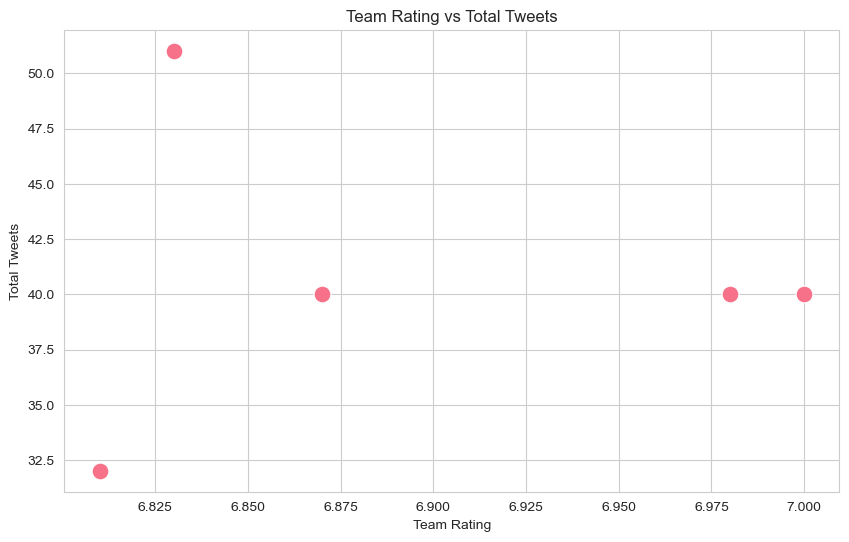

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# converting coluumns to numerics
teams_df['rating'] = pd.to_numeric(teams_df['rating'], errors='coerce')

# counting the tweets per team as per the scraped data file
tweets_df = pd.read_csv('team_tweets.csv')
tweet_counts = tweets_df['team_name'].value_counts()

team_name_map = {
    'ManCity': 'Manchester City',
    'ManUtd': 'Manchester United',
    'Arsenal': 'Arsenal',
    'ChelseaFC': 'Chelsea',
    'LFC': 'Liverpool'
}

teams_df['total_tweets'] = teams_df['team_name'].map(
    lambda x: tweet_counts.get([k for k, v in team_name_map.items() if v == x][0], 0)
)

plt.figure(figsize=(10,6))

sns.scatterplot(data=teams_df, x='rating', y='total_tweets', s=150)
plt.xlabel('Team Rating')
plt.ylabel('Total Tweets')
plt.title('Team Rating vs Total Tweets')
plt.show()

#### Data Usage and Remaining Issues
We have gathered data for the teams' statistics and on-field performance, along with data from a social media page such as Twitter (or X). Moreover, we have curated diagrams that display the correlations between these two categories and how they could relate to each other. What we still need to continue with is sentimental analysis for comments on the original twitter post of the teams, and how these comments could relate to the team's performance. We could also compare this with the morale of the team, showcasing how these comments could affect their performance. Another aspect we could also focus on is how the number of comments/interactions/replies to the original twitter post could depend on the result of the football game that each team just played.